---
title: "Class Session 10 - Date Hubs and Party Hubs"
author: "Trent VanHawkins"
date: today
format: 
    pdf:
        geometry: "margin=0.75in"
        mathspec: true
        code-overflow: wrap
        cap-location: bottom
        tbl-cap-location: bottom
        header-includes: 
        - \usepackage{fancyhdr, amsthm, amssymb,amsfonts,amsthm, amsmath, bbm}
        - \usepackage{float, tabularx}
        - \floatplacement{table}{H}
        - \pagestyle{fancy}
        - \fancyhead[R]{Notebook 9}
        - \fancyhead[L]{Trent VanHawkins}
        - \fancyfoot[C]{\thepage} # Center page number at bottom of each page
page-layout: full
execute: 
  eval: true
---

## Comparing the histograms of local clustering coefficients of date hubs and party hubs

In this class, we will analyze the protein-protein interaction network for two classes of yeast proteins, "date hubs" and "party hubs" as defined by Han et al. in their 2004 study of protein-interaction networks and gene expression (Han et al., Nature, v430, p88, 2004). The authors of that study claimed that there is no difference in hub genes' local clustering coefficient density distributions, between "date hubs" and "party hubs".  We will put this to the test. We for each of the "date hub" and "party hub" proteins, we will compute its local clustering coefficient (Ci) in the protein-protein interaction network.  We will then histogram the Ci values for the two sets of hubs, so that we can compare the distributions of local clustering coefficients for "date hubs" and "party hubs". We will use a statistical test (Kolmogorov-Smirnov) to compare the two distributions of Ci values.

To get started, we load the modules that we will require (`igraph`, `numpy`, `pandas`, `scipy.stats`, and `matplotlib.pyplot`):

In [1]:
import igraph
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

Next, we'll load the file of hub types `han_hub_data.txt` (which is a two-column TSV file in which the first column is the protein name and the second column contains the string `date` or `party` for each row; the first row of the file contains the column headers), using our old friend `pandas.read_csv`. This file has a header so pass `header=0` to `read_csv`.

In [ ]:
!curl https://csx46.s3-us-west-2.amazonaws.com/han_hub_data.txt > ../DataRaw/han_hub_data.txt
hub_data = pd.read_csv('../DataRaw/han_hub_data.txt', sep='\t', header = 0)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2175  100  2175    0     0  28349      0 --:--:-- --:--:-- --:--:-- 28618


,Protein,HubType
0,ACT1,date
1,ADA2,date
2,AKR1,party
3,APC1,party
4,APC11,date


Let's take a peek at the structure of the `hub_data` data frame, using `head` and `shape`.  Here's what it should look like:

In [4]:
hub_data.head()


,Protein,HubType
0,ACT1,date
1,ADA2,date
2,AKR1,party
3,APC1,party
4,APC11,date


In [5]:
hub_data.shape

(198, 2)

Next, let's load the file of yeast protein-protein interaction network edges `han_network_edges.txt` (which is a two-column file, with first column is the first protein in the interacting pair, and the second column is the second protein in the interacting pair).This file has a header so pass `header=0` to `read_csv`.

In [6]:
!curl https://csx46.s3-us-west-2.amazonaws.com/han_network_edges.txt > ../DataRaw/han_network_edges.txt
edge_data = pd.read_csv("../DataRaw/han_network_edges.txt", sep = "\t", header = 0)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23439  100 23439    0     0   247k      0 --:--:-- --:--:-- --:--:--  248k


Let's take a peek at the data frame `edge_df`, using `head` and `shape`:

In [ ]:
edge_df.head()

,PROTEINA,PROTEINB
0,AAR2,PRP8
1,ABP1,SRV2
2,ABP1,ACT1
3,ABP1,RVS167
4,ACT1,IQG1


In [ ]:
edge_df.shape

(2125, 2)

When loading an undirected network in edge-list format, it's always a good idea to reorder the vertices within each row, so that the column 2 vertex is (lexicographically) greater than the column 1 vertex. Then we can call `drop_duplicates` on the dataframe and be confident that we don't have a multigraph, because we won't get a situation where we have two edges:
```
A--B
B--A
```
in the edge-list dataframe. Go ahead and do this on `edge_data` (see Notebook 3 for details) and then call `drop_duplicates` and reassign the resulting dataframe to `edge_data`. What is the shape of `edge_data` now?

In [7]:
inds = edge_data['PROTEINB'] > edge_data['PROTEINA']
temp = edge_data.loc[inds, ['PROTEINB', 'PROTEINA']]
edge_data.loc[inds, ['PROTEINA', 'PROTEINB']] = temp.values
edge_data = edge_data.drop_duplicates()
edge_data.shape

(2125, 2)

make an undirected igraph `Graph` from the edgelist data; show summary data on the graph as a sanity-check

In [9]:
ppi_graph = igraph.Graph.TupleList(edge_data.values.tolist(), directed= False)
ppi_graph.summary()

'IGRAPH UN-- 1285 2125 -- \n+ attr: name (v)'

Generate a list of the names of the proteins in the order of the proteins' corresponding vertices in the igraph `Graph` object, by referencing the `.vs` object and indexing into it using `["name"]`.

Another sanity-check you can perform on the igraph graph is to call `is_simple` on it. Let's do that now.

In [11]:
ppi_graph.is_simple()

True

Let's grab the vertex names by obtaining the `VertexSeq` object in the `.vs` object variable, and then index into that `VertexSeq` object using `["name"]`. Assign the resulting list to `graph_vertices`.

In [12]:
graph_vertices = ppi_graph.vs["name"]

Print the first ten entries of `graph_vertices`

In [18]:
graph_vertices[0:10]

['PRP8',
 'AAR2',
 'SRV2',
 'ABP1',
 'ACT1',
 'RVS167',
 'IQG1',
 'AIP1',
 'COF1',
 'OYE2']

Make a pandas.DataFrame containing the protein names `graph_vertices`(as column `Protein`) and the vertex IDs `graph_vertices_df.index` (as column `order`), and print its first five rows using `head`:

In [16]:
graph_vertices_df = pd.DataFrame({"Protein": graph_vertices})

graph_vertices_df["order"] = graph_vertices_df.index

graph_vertices_df.head()


,Protein,order
0,PRP8,0
1,AAR2,1
2,SRV2,2
3,ABP1,3
4,ACT1,4


Let's use the `pandas.DataFrame.merge` method on the `graph_vertices_df` object to pull in the hub type (date or party) for vertices that are hubs, by passing `hub_data` to `merge`.  Don't forget to specify `how='outer'` and `on="Protein"`:

In [21]:
graph_vertices_df_merged = graph_vertices_df.merge(hub_data, how='outer', on="Protein")
graph_vertices_df_merged = graph_vertices_df_merged.sort_values("order")


Having merged the hub type information into `graph_vertices_df_merged`, let's take a peek at it using `head` and `shape`:

In [22]:
graph_vertices_df_merged.head()

,Protein,order,HubType
657,PRP8,0,party
1,AAR2,1,NaN
1041,SRV2,2,NaN
2,ABP1,3,NaN
4,ACT1,4,date


In [ ]:
graph_vertices_df_merged.shape

(1285, 2)

Let's pull out the `HubType` column as a numpy array, using column indexing (`["HubType"]`) and then `.to_numpy().tolist()`:

In [28]:
vertex_types_np = np.array(graph_vertices_df_merged["HubType"].to_numpy().tolist())

Let's take a peek at this `numpy.array` that we have just created:

In [29]:
vertex_types_np[0:10]

array(['party', 'nan', 'nan', 'nan', 'date', 'party', 'nan', 'nan', 'nan',
       'nan'], dtype='<U32')

Use `numpy.where` in order to find the index numbers of the proteins that are "date hubs" and that are "party hubs":

In [30]:
date_hub_inds = np.where(vertex_types_np == 'date')
party_hub_inds = np.where(vertex_types_np == 'party')

Use the `igraph.Graph.transitivity_local_undirected` function in igraph to compute the local clustering coefficients for every vertex in the graph. Make a `numpy.array` from the resulting list of Ci values and assign it to `ci_values_np`.

In [31]:
ci_values = ppi_graph.transitivity_local_undirected()
ci_values_np = np.array(ci_values)

Let's take a peek at the `ci_values_np` array that you have just created.  What are the `nan` values, and what do they signify?  Is this normal?

In [33]:
ci_values_np

array([0.10714286,        nan, 0.33333333, ..., 0.        ,        nan,
              nan], shape=(1285,))

Make a `numpy.array` of the Ci values of the date hubs (`ci_values_date_hubs`) and the Ci values of the party hubs (`ci_values_party_hubs`). Make sure to delete NaN values from each of the two
vectors.

In [34]:
ci_values_date_hubs = ci_values_np[date_hub_inds]
ci_values_date_hubs = ci_values_date_hubs[~np.isnan(ci_values_date_hubs)]
ci_values_party_hubs = ci_values_np[party_hub_inds]
ci_values_party_hubs = ci_values_party_hubs[~np.isnan(ci_values_party_hubs)]

Using `matplotlib.pyplot`, plot the histograms of the local clustering coefficients of the "date hubs" and the "party hubs".

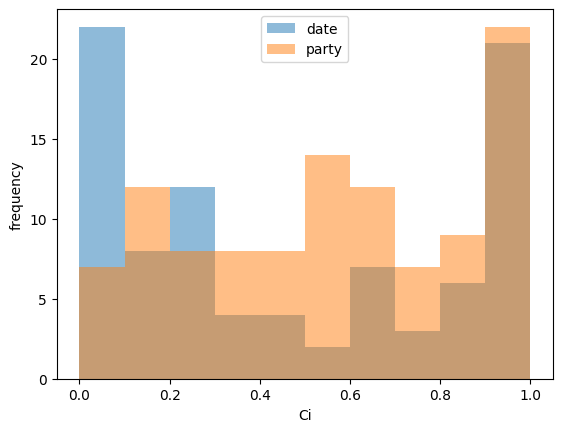

In [35]:
plt.hist(ci_values_date_hubs, alpha=0.5, label="date")
plt.hist(ci_values_party_hubs, alpha=0.5, label="party")
plt.legend(loc="upper center")
plt.xlabel("Ci")
plt.ylabel("frequency")
plt.show()

Do these histograms look the same?

Test the two sets of Ci samples using the Kolmogorov-Smirnov test. Are the two empirical distributions statistically distinguishable?

In [37]:
scipy.stats.ks_2samp(ci_values_date_hubs, ci_values_party_hubs)

KstestResult(statistic=np.float64(0.23458994014491233), pvalue=np.float64(0.007704144574627679), statistic_location=np.float64(0.3333333333333333), statistic_sign=np.int8(1))